In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

2024-04-19 11:21:22.777522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 11:21:22.777622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 11:21:23.021908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
data = '/kaggle/input/asl-dataset-aug/Dataset'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [9]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df,  train_size = 0.8, shuffle = True, random_state = 42, stratify = df['Labels'])
valid_df, test_df = train_test_split(dummy_df,  train_size = 0.5, shuffle = True, random_state  = 42, stratify = dummy_df['Labels'])

In [40]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,  # Rescale pixel values to [0, 1]
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepaths',
    y_col = 'Labels',
    target_size = (150, 150),
    batch_size = 50,
    class_mode = 'categorical',  # Use 'categorical' for multi-class classification
    shuffle = True,
    seed = 42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = valid_df,
    x_col = 'Filepaths',
    y_col = 'Labels',
    target_size = (150, 150),
    batch_size = 50,
    class_mode = 'categorical',
    shuffle = False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepaths',
    y_col = 'Labels',
    target_size = (150, 150),
    batch_size = 50,
    class_mode = 'categorical',
    shuffle = False  # No need to shuffle test data
)

Found 436 validated image filenames belonging to 26 classes.
Found 55 validated image filenames belonging to 26 classes.
Found 55 validated image filenames belonging to 26 classes.


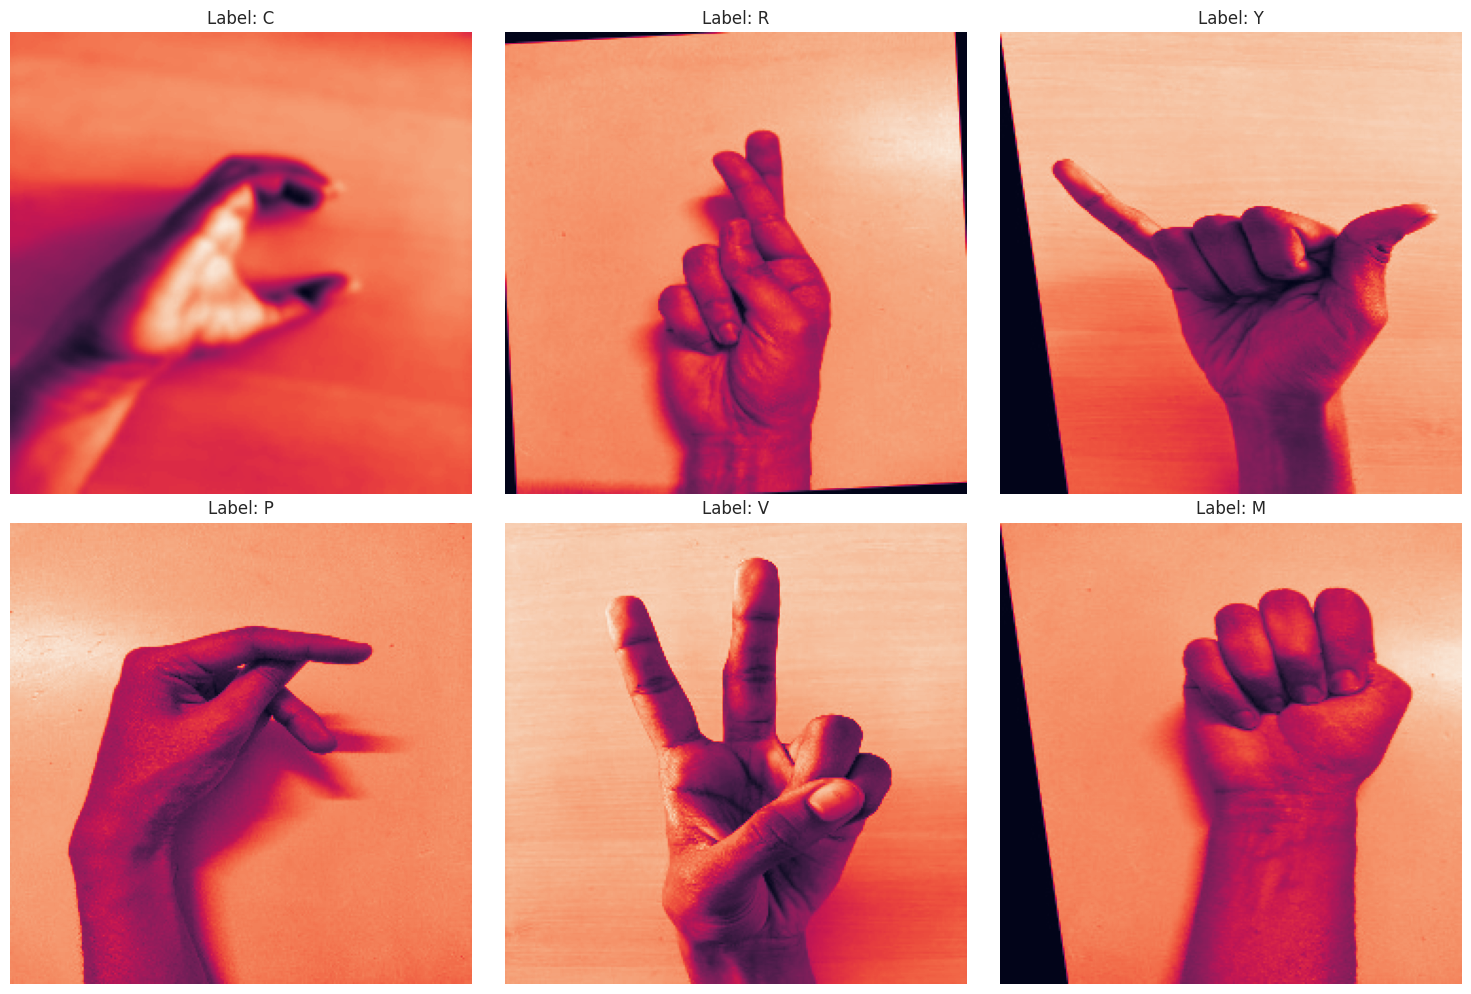

In [11]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples = 6):
    plt.figure(figsize = (15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.xception import Xception


# Model architecture
base_model = Xception(weights = 'imagenet', include_top=False, input_shape=(150,150,3), pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])


model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
history = model.fit(
    x = train_generator ,
    validation_data = valid_generator ,
    epochs = 20 , verbose = 1 ,
    validation_steps = None, shuffle  = False
   )

Epoch 1/20


W0000 00:00:1713527484.721997     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.0642 - loss: 4.0205

W0000 00:00:1713527526.599778     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0723 - loss: 3.9722   

W0000 00:00:1713527530.253877     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step - accuracy: 0.0788 - loss: 3.9336 - val_accuracy: 0.1273 - val_loss: 3.7477
Epoch 2/20


W0000 00:00:1713527534.371948     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.4525 - loss: 2.0626 - val_accuracy: 0.2909 - val_loss: 2.3528
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.7093 - loss: 0.9778 - val_accuracy: 0.4727 - val_loss: 1.5747
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.8532 - loss: 0.4696 - val_accuracy: 0.5636 - val_loss: 1.0707
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.9284 - loss: 0.2322 - val_accuracy: 0.7091 - val_loss: 0.5740
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.9461 - loss: 0.2404 - val_accuracy: 0.8182 - val_loss: 0.3236
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.9745 - loss: 0.0802 - val_accuracy: 0.8545 - val_loss: 0.2811
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.9669 - loss: 0.0934 - val_accuracy: 0.8909 - val_loss: 0.2090
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.9820 - loss: 0.0630 - val_accuracy: 0.9273 - val_loss: 0.2217
Epo

In [42]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9812 - loss: 0.0445 
Test Accuracy: 0.9818181991577148


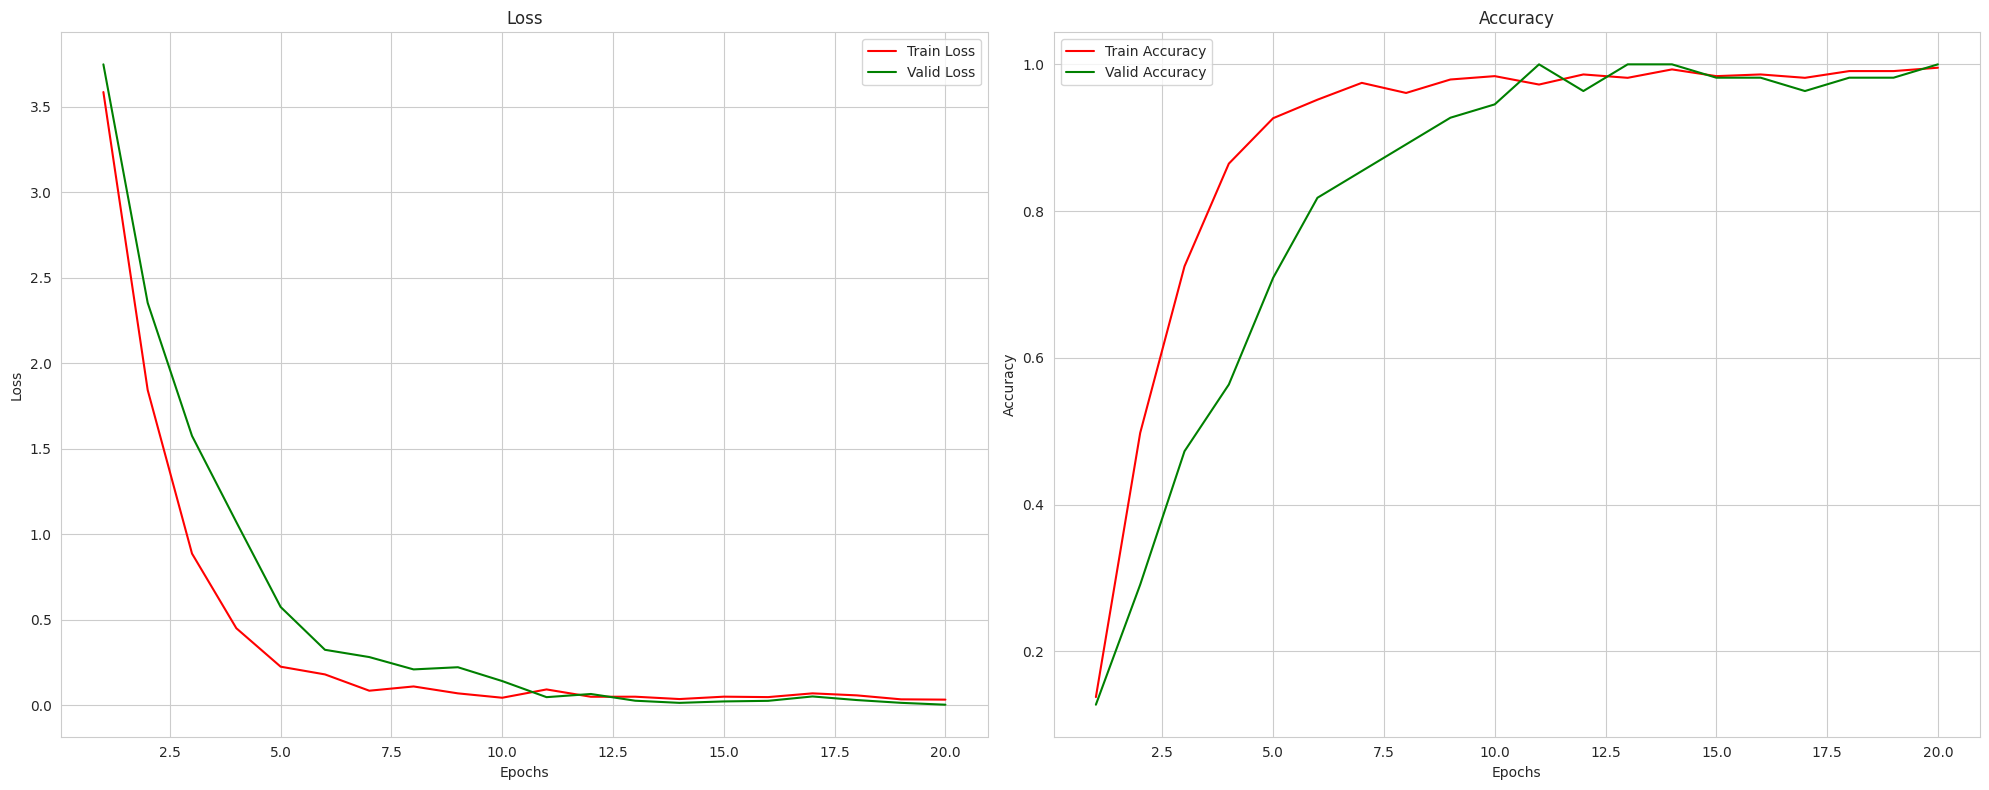

In [43]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i + 1 for i in range(len(tr_acc))]

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label = 'Train Loss')
plt.plot(epochs, val_loss, 'g', label = 'Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

W0000 00:00:1713527626.682040     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


W0000 00:00:1713527629.469457     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


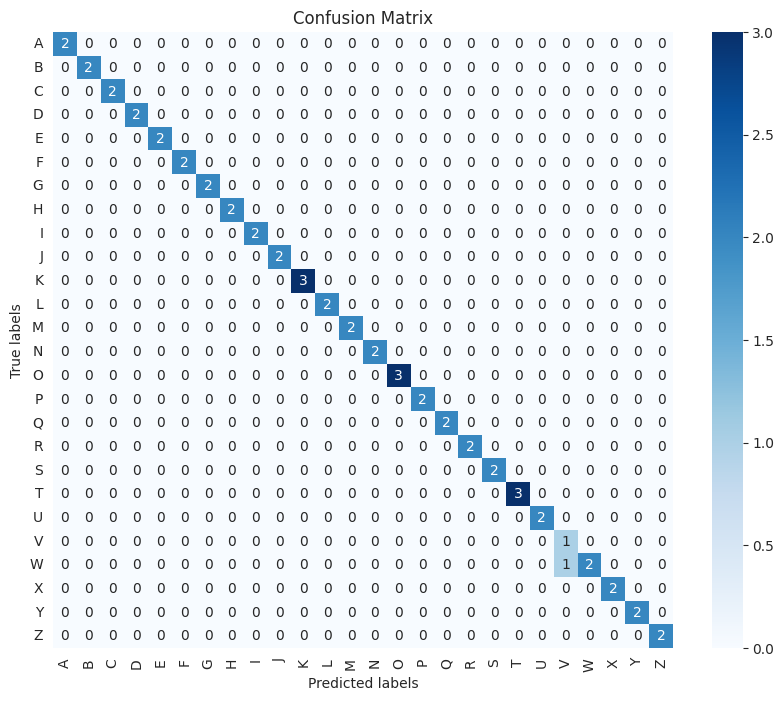


Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         2
           B       1.00      1.00      1.00         2
           C       1.00      1.00      1.00         2
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00         2
           F       1.00      1.00      1.00         2
           G       1.00      1.00      1.00         2
           H       1.00      1.00      1.00         2
           I       1.00      1.00      1.00         2
           J       1.00      1.00      1.00         2
           K       1.00      1.00      1.00         3
           L       1.00      1.00      1.00         2
           M       1.00      1.00      1.00         2
           N       1.00      1.00      1.00         2
           O       1.00      1.00      1.00         3
           P       1.00      1.00      1.00         2
           Q       1.00      1.00      1.00         2
   

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Assuming you have already trained your model and obtained predictions
# X_test: Test images, y_test: True labels, model: Trained CNN model

# Get predictions for the test set
y_pred = np.argmax(model.predict(test_generator), axis = -1)

# Get class indices from the test generator
class_indices = test_generator.class_indices

# Map class indices to class names
class_names = {v: k for k, v in class_indices.items()}

# Sort class names based on their indices
class_names = [class_names[i] for i in sorted(class_names.keys())]

# Print confusion matrix
conf_matrix = confusion_matrix(y_pred, test_generator.classes)

# Plot confusion matrix
plt.figure(figsize = (10, 8))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation = 'vertical')
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation = 'horizontal')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred, target_names = class_names))

In [45]:
base_folder = '/kaggle/input/isl-dataset/ISL_Final'
isl_dict = {}
for folder in os.listdir(base_folder):
    key = folder[-1]
    image_path = (base_folder + "/" + folder)
    im_no = random.randrange(0, 45)
    value = image_path + "/" + os.listdir(image_path)[im_no]    
    isl_dict[key] = value
    
        

In [30]:
alpha_map = [chr(ord('A') + i) for i in range(0,26)]

In [31]:
# importing required libraries 
import matplotlib.pyplot as plt 
import matplotlib.image as img

def displayISL(predicted_alphabet):
    # reading the image 
    testImage = img.imread(isl_dict[predicted_alphabet]) 
    
    # displaying the image 
    plt.imshow(testImage)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
R


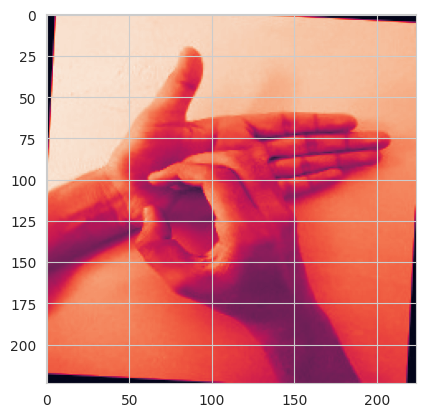

In [47]:
import cv2
import numpy as np

# Load the image
image_path = '/kaggle/input/asl-dataset-aug/Dataset/R/R.jpg4.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (150, 150))  # Resize to match model input shape
image = np.expand_dims(image, axis = 0)  # Add batch dimension
image = image / 255.0  # Normalize pixel values
# Predict the class probabilities for the image
predictions = model.predict(image)

# Get the predicted class label
predicted_class = np.argmax(predictions)

print(alpha_map[predicted_class])
# displayISL(predicted_class)
displayISL(alpha_map[predicted_class])